# High Value Customer Indentification (Insiders)

## Solution Planning

### Input

#### Problema de negócio

1. Selecionar os clientes mais valiosos para integrar o programa de fidelidade **INSIDERS**.
2. Conjunto de dados de vendas de um e-commerce durante um ano.

### Output

1. Indicação das pessoas que farão parte do programa de Insiders
    * Lista:<br>
        client_id | is_insider |<br>
        10515 | yes/1 |<br>
        65638 | no/0 |
2. Relatório com as respostas das perguntas de negócio
    * Quem são as pessoas elegíveis para participar do programa de Insiders?
    * Quantos clientes farão parte do grupo?
    * Quais as principais características desses clientes?
    * Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    * Qual a expectativa de faturamento desse grupo para os próximos meses?
    * Quais as condições para uma pessoa ser elegível ao Insiders?
    * Quais as condições para uma pessoa ser removida do Insiders?
    * Qual a garantia que o programa Insiders é melhor que o restante da base?
    * Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks

1. Quem são as pessoas elegíveis para participar do programa de Insiders?

    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV (Lifetime Value)
        - Baixa Recência ou Alta frequência (tempo entre as compras)
        - Alto basket size (quantidade média de produtos comprados)
        - Baixa probabilidade de Churn
        - Previsão de alta LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
    - Experiência de compra:
        - Média alta das avaliações
        
    
2. Quantos clientes farão parte do grupo?

    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes?

    - Características do cliente, como:
        - Idade
        - Localização
        - Salário
        
    - Características do consumo, como:
        - Atributos da clusterização
        
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses?

    - LTV do grupo Insiders
    - Análise de Cohort
    
    
6. Quais as condições para uma pessoa ser elegível ao Insiders?

    - O desempenho do cliente está próximo da média do cluster Insiders.
    

7. Quais as condições para uma pessoa ser removida do Insiders?

    - O desempenho do cliente não está mais próximo da média do cluster Insiders.
    
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base?

    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

    - Desconto
    - Preferência de compra
    - Produtos exclusivos
    - Visita à empresa

## 0.0 Imports

In [5]:
import inflection
import numpy as np
import pandas as pd
import re
import seaborn as sns
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML
from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster        import hierarchy as hc
from ydata_profiling import ProfileReport

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings

### 0.1 Helper Functions

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [9,5]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:95%!important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    
    sns.set()
jupyter_settings()
pd.set_option('display.float_format', lambda x: f'{x:.2f}');
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [7]:
def silhouette_plots(model_name,clusters,X):
    fig, ax = plt.subplots(3, 3)
    fig.set_size_inches(25, 20)
    
    for i, k in enumerate(clusters[:9]):
        q, mod = divmod(i, 3)
        
        ax[q, mod].set_xlim([-0.1, 1])
        ax[q, mod].set_ylim([0, len(X) + (k+1)*10])
    
        if model_name == 'hc':
            fig.suptitle('Hierarchical', fontsize=25)
            
            # model definition & training
            hc_model = hc.linkage(X, 'ward')
        
            # model predict
            labels = hc.fcluster(hc_model, k, criterion='maxclust')
        
            # performance
            ss = metrics.silhouette_score(X, labels, metric='euclidean')
            # print(f'For k: {k}. Silhouette Score: {ss}')
            
        elif model_name == 'gmm':
            fig.suptitle('GMM', fontsize=25)
            
            # Model definition
            gmm_model = GaussianMixture(n_components=k)
        
            # Model training
            gmm_model.fit(X)
        
            # Model predict
            labels = gmm_model.predict(X)
        
            # Model performance
            ss = metrics.silhouette_score(X, labels, metric='euclidean')
            # print(f'For k: {k}. Silhouette Score: {ss}')
        
        samples_silhouette_values = metrics.silhouette_samples(X, labels)
        
        y_lower = 10
        
        for i in range(k):
            # select clusters
            ith_samples_silhouette_values = samples_silhouette_values[labels == i]
            
            # sort values
            ith_samples_silhouette_values.sort()
            
            # size clusters
            size_cluster_i = ith_samples_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap('Spectral')
            color = cmap(i/k)
            
            ax[q, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
            
            # Label the silhouette plots with their cluster numbers at the middle
            ax[q, mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            
            y_lower = y_upper + 10
        
        ax[q, mod].set_yticks([])
        ax[q, mod].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # The vertical line for average silhouette score of all the values
        ax[q, mod].axvline(x=ss, color="red", linestyle="--")
        
        ax[q, mod].set_title(f'Visualization for {k} clustered data.')
        ax[q, mod].set_xlabel(f"Silhouette score: {ss}")
        ax[q, mod].set_ylabel("Cluster label")

### 0.2 Load Dataset

In [8]:
df_raw = pd.read_csv("Ecommerce.csv", encoding="unicode=escape")
df_raw = df_raw.iloc[:,:-1]

## 1.0 Data Description

In [9]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [10]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
df1.columns = [inflection.underscore(col) for col in df1.columns]

### 1.2 Data Dimension

In [12]:
print('Number of rows: {}'.format(len(df1.index)))
print('Number of columns: {}'.format(len(df1.columns)))

Number of rows: 541909
Number of columns: 8


### 1.3 Data types

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4 Check NA

In [14]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [15]:
# Separating null values for customer id
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[~df1['customer_id'].isna()]

# Search for corresponding customer ids through invoice number
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
df_not_missing[df_not_missing['invoice_no'].isin(missing_invoice)]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

#### Creation of Customer ID

In [16]:
# Creating reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# Merging dataframes
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.6 Change dtypes

In [18]:
df1.head(3)

invoice_no stock_code                         description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A  WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55  United Kingdom     17850.00
1     536365      71053                 WHITE METAL LANTERN         6    29-Nov-16        3.39  United Kingdom     17850.00
2     536365     84406B      CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75  United Kingdom     17850.00

In [19]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')
df1['customer_id'] = df1['customer_id'].astype('int64')

In [20]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7 Descriptive Statistics

In [21]:
# Separating numerical and categorical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [25]:
describe = num_attributes.describe().T
describe.insert(2,'median',num_attributes.apply(np.median))
describe['range']    = num_attributes.apply(lambda x: x.max() - x.min())
describe['skew']     = num_attributes.apply(lambda x: x.skew())
describe['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
describe

count     mean   median     std       min      25%      50%      75%      max     range   skew  kurtosis
quantity    541909.00     9.55     3.00  218.08 -80995.00     1.00     3.00    10.00 80995.00 161990.00  -0.26 119769.16
unit_price  541909.00     4.61     2.08   96.76 -11062.06     1.25     2.08     4.13 38970.00  50032.06 186.51  59005.72
customer_id 541909.00 16688.84 16249.00 2911.41  12346.00 14367.00 16249.00 18283.00 22709.00  10363.00   0.49     -0.80

#### 1.7.2 Categorical Attributes

In [24]:
cat_attributes.sample(10)

invoice_no stock_code                       description         country
302452     563432      22169  FAMILY ALBUM WHITE PICTURE FRAME  United Kingdom
475315     576876      23355        HOT WATER BOTTLE KEEP CALM  United Kingdom
463842     576073      21117               BLOND DOLL DOORSTOP  United Kingdom
35172      539434     72351B    SET/6 PINK  BUTTERFLY T-LIGHTS  United Kingdom
383086    C569996     79191C       RETRO PLASTIC ELEPHANT TRAY  United Kingdom
164436     550639      22834       HAND WARMER BABUSHKA DESIGN  United Kingdom
353615     567818      23389            SPACEBOY MINI BACKPACK  United Kingdom
220584     556201      23146    TRIPLE HOOK ANTIQUE IVORY ROSE         Iceland
254575     559321      23205   CHARLOTTE BAG VINTAGE ALPHABET   United Kingdom
289327     562264      21447  12 IVORY ROSE PEG PLACE SETTINGS  United Kingdom

#### Invoce with letters

In [25]:
# Invoice no
# some invoices have letters
invoices_with_letters = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

negative_quantity = invoices_with_letters[invoices_with_letters['quantity'] < 0]

if len(invoices_with_letters) == len(negative_quantity):
    print('All invoces with letter have negative quantity.')
    print(f'# invoices: {len(invoices_with_letters)}')
    print(f'# negative quantity: {len(negative_quantity)}')
else:
    print('Negative quantity is not related to invoce codes with letters')
    print(f'# invoices: {len(invoices_with_letters)}')
    print(f'# negative quantity: {len(negative_quantity)}')

Negative quantity is not related to invoce codes with letters
# invoices: 9291
# negative quantity: 9288


#### Stock codes with only letters

In [26]:
# Stock code only characters
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Ação: Remover stock_codes listados acima

#### Description

In [27]:
len(df1['description'].unique())

4224

Ação: Remover coluna description para simplificar as dimensionalidade, devido a alta variedade de valores distintos

#### Countries

In [28]:
cat_attributes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [29]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

country  customer_id
36  United Kingdom         7587
14         Germany           95
13          France           90
10            EIRE           44
31           Spain           31

European Community/Unspecified: Não há indicativo de quais países que englobam essa categoria

Ação: Padronizar os nomes dos países

## 2.0 Variable Filtering

In [30]:
df2 = df1.copy()

In [31]:
# unit_price
df2 = df2[df2['unit_price'] > 0.04]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns=['description'])

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# Removing bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity
df2_returns   = df2[df2['quantity'] < 0]
df2_purchases = df2[df2['quantity'] >= 0]

## 3.0 Feature Engineering

In [32]:
df3 = df2.copy()

### 3.1 Feature Creation

In [33]:
# Creating a dataframe with unique customer ids
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)

In [34]:
df_ref.size

5786

#### 3.1.1 Gross Revenue

In [35]:
# Gross Revenue (quantity * price)
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases.groupby('customer_id')[['gross_revenue']].sum().reset_index()
df_monetary['gross_revenue'] = df_monetary['gross_revenue'].astype(float)

# Merging dataframes
df_ref = pd.merge(df_ref,df_monetary,on='customer_id',how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2 Recency - Days From Last Purchase

In [36]:
# Recency - Last day purchase
df_recency = df2_purchases.groupby('customer_id')[['invoice_date']].max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

# Merging dataframes
df_ref = pd.merge(df_ref,df_recency,on='customer_id',how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.3 Quantity of Purchases

In [37]:
# Number of purchases
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases[['customer_id',
                         'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':
                                                                                                                       'qty_invoices'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

#### 3.1.4 Quantity of Distinct Products in Each Purchase

In [38]:
# Number of products purchased
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases.groupby('customer_id')['stock_code'].nunique().reset_index().rename(columns={'stock_code': 'qty_products'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
dtype: int64

#### 3.1.5 Quantity of Items Purchased

In [39]:
# Number of items purchased
# Creating dataframe with number of purchases for each customer
df_freq = df2_purchases.groupby('customer_id')['quantity'].sum().reset_index().rename(columns={'quantity': 'qty_items'})

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
dtype: int64

#### 3.1.8 Frequency

In [40]:
# Aggregating max, min, number of days and number of purchases
df_aux = df2_purchases[['customer_id',
                        'invoice_no',
                        'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_ = ('invoice_date', 'max'),
                                                                                      min_ = ('invoice_date', 'min'),
                                                                                      days_ = ('invoice_date', 
                                                                                               lambda x: ((x.max() - x.min()).days)+1),
                                                                                      buy_ = ('invoice_no', 'count')
                                                                                      ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: (x['buy_']/x['days_'])
                                                      if x['days_'] != 0 else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
frequency        91
dtype: int64

#### 3.1.9 Number of Returns

In [41]:
# Number of Returns
df_returns = df2_returns.groupby('customer_id')['quantity'].sum().reset_index().rename(columns={'quantity':'qty_returns'})

df_returns['qty_returns'] = df_returns['qty_returns']*-1

# Merging dataframes
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_products     91
qty_items        91
frequency        91
qty_returns       0
dtype: int64

In [42]:
df_ref.sample(5)

customer_id  gross_revenue  recency_days  qty_invoices  qty_products  qty_items  frequency  qty_returns
2214        14504         673.26         47.00          4.00         85.00     308.00       0.02         0.00
1006        16686        3062.83         47.00          7.00        406.00    2030.00       0.02         5.00
4989        22004          20.53         58.00          1.00          5.00      35.00       1.00         0.00
2379        14636         609.85         36.00          2.00         27.00     241.00       0.01         0.00
1858        19659           8.50        298.00          1.00          1.00       1.00       1.00         0.00

## 4.0 EDA (Exploratory Data Analysis)

**Metrics:**
1. Cohesive Cluster - Separated
2. Metrics
 * Min, Max, Range (dispersion)
 * Mean and Median
 * Standard Deviation and Variance
 * Coefficient of Variation (CV)

In [43]:
df4 = df_ref.dropna()

In [44]:
# Pandas Profiling 
profile = ProfileReport(df4)

In [24]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1 Univariate Analysis

### 4.2 Bivariate Analysis

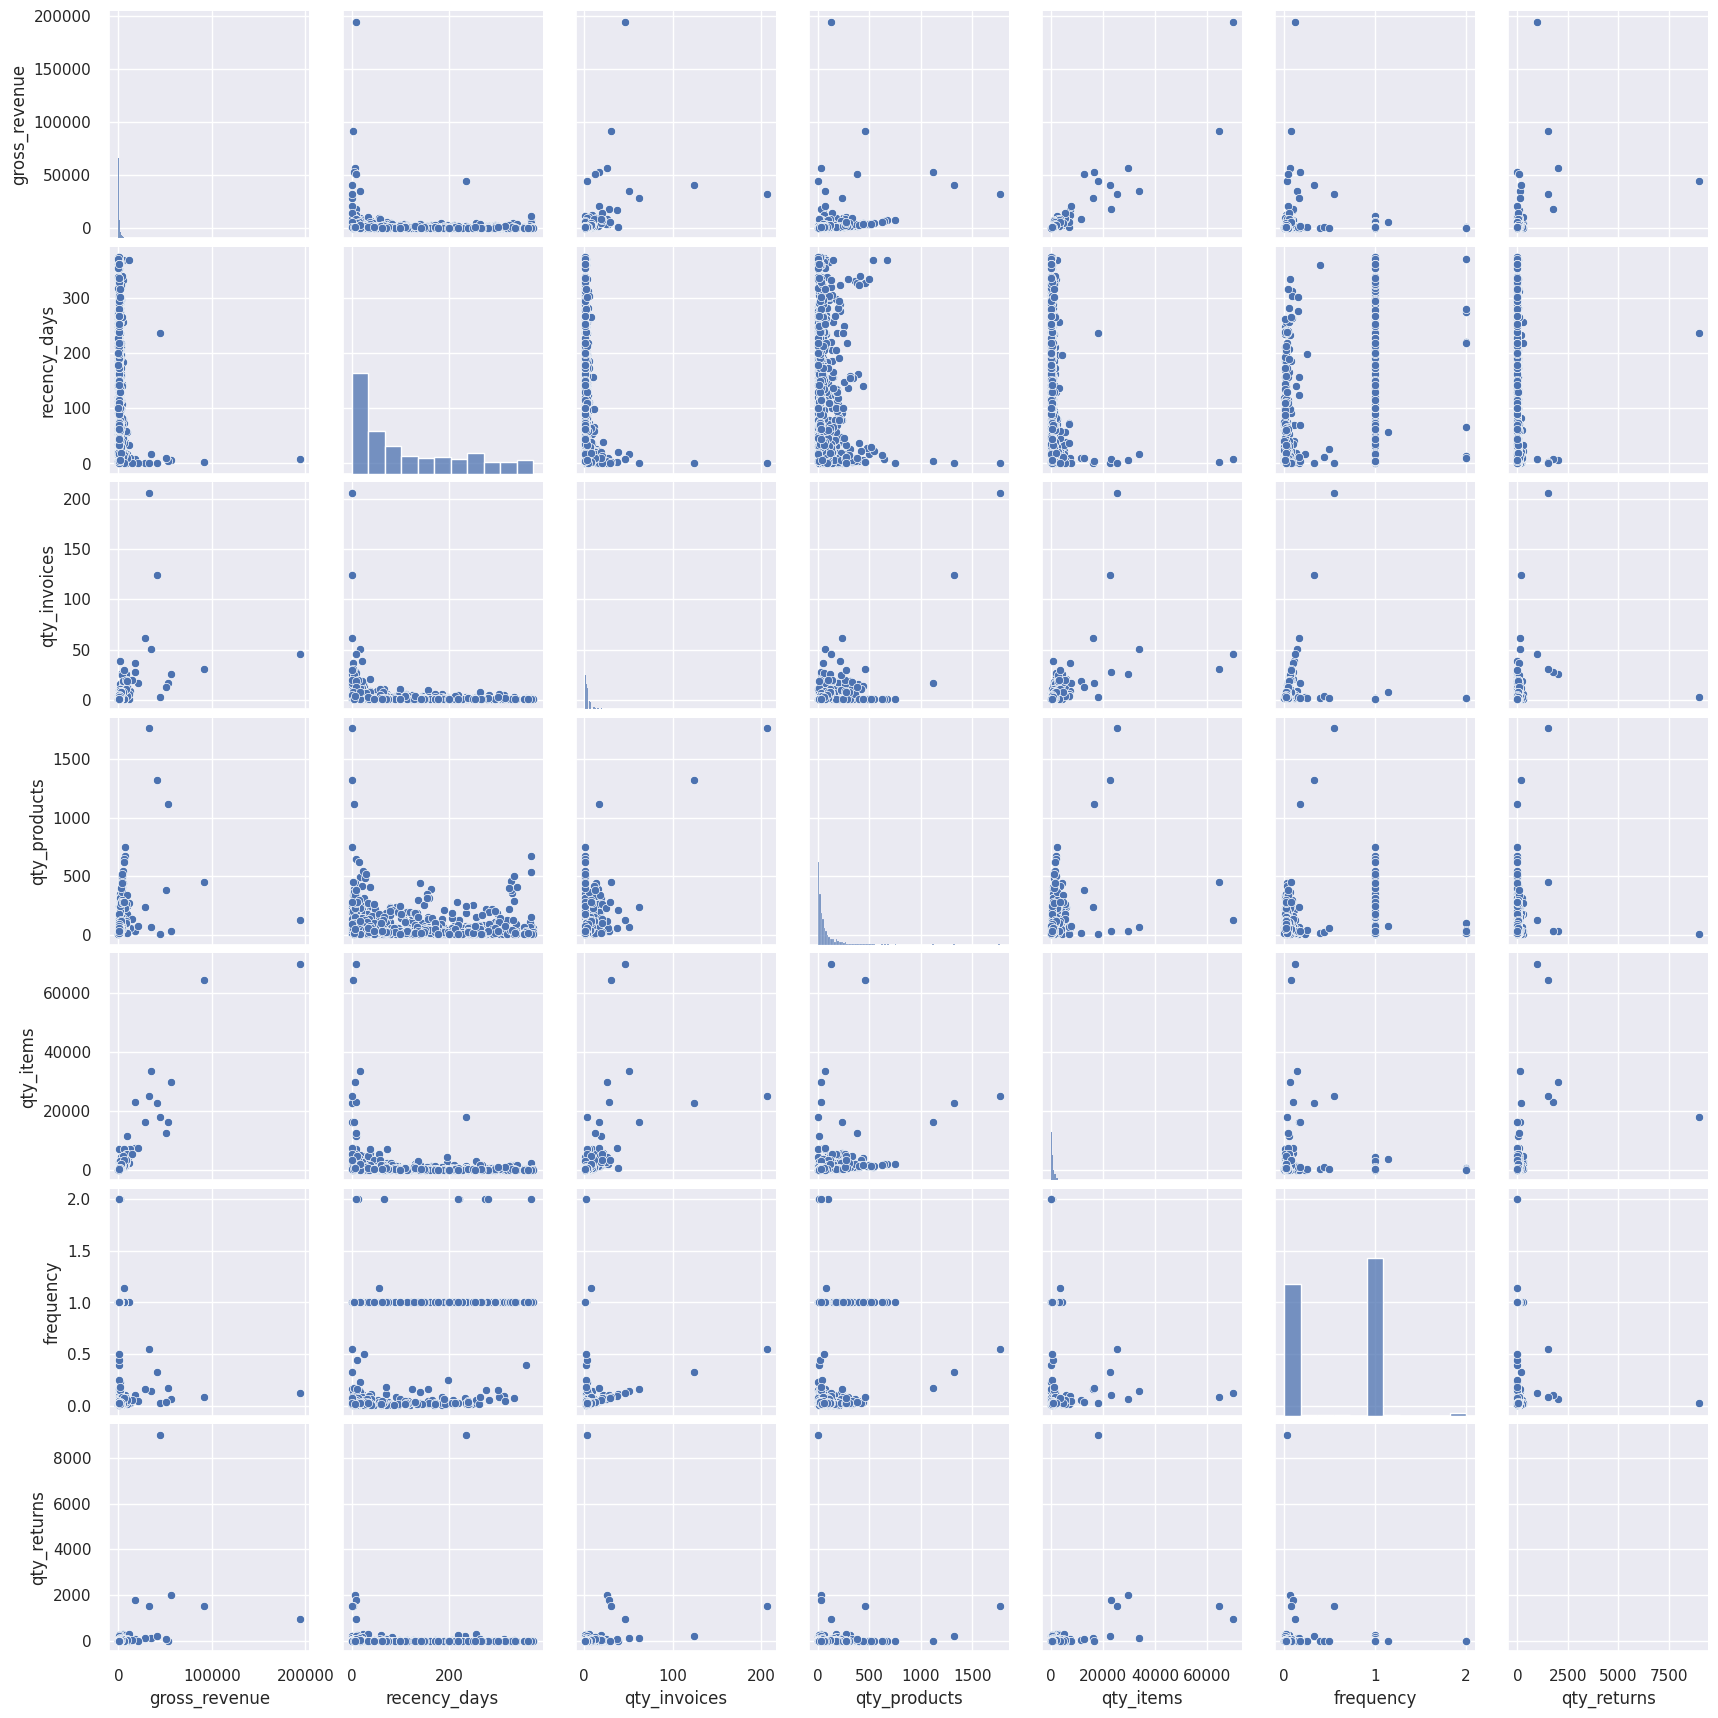

In [48]:
df_sample = df4.drop('customer_id', axis=1).sample(1000)
sns.pairplot(df_sample);

### 4.3 Space Study

In [49]:
cols_selected = ['gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']

In [50]:
df43 = df4[cols_selected]

#### Encoding

In [51]:
# Encoding features with Min Max Scaler
mm = pp.MinMaxScaler()

for col in df43.columns:
    df43[col] = mm.fit_transform(df43[[col]])

X = df43.copy()

#### 4.3.1 PCA

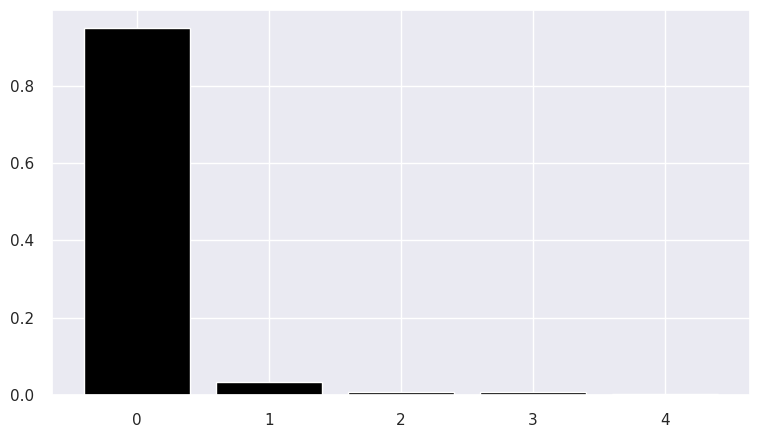

In [52]:
# Define number of components for PCA as number of columns
pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# Plot explained variables
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

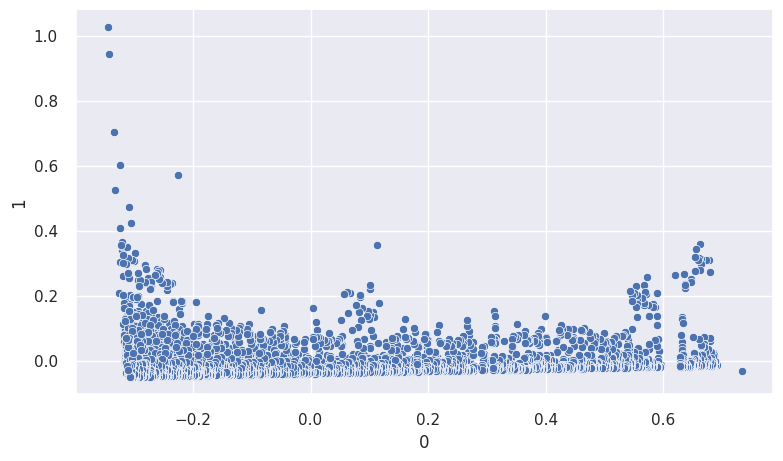

In [53]:
# Plot Component 0 and 1
sns.scatterplot(x=0, y=1, data=df_pca);

#### 4.3.2 UMAP

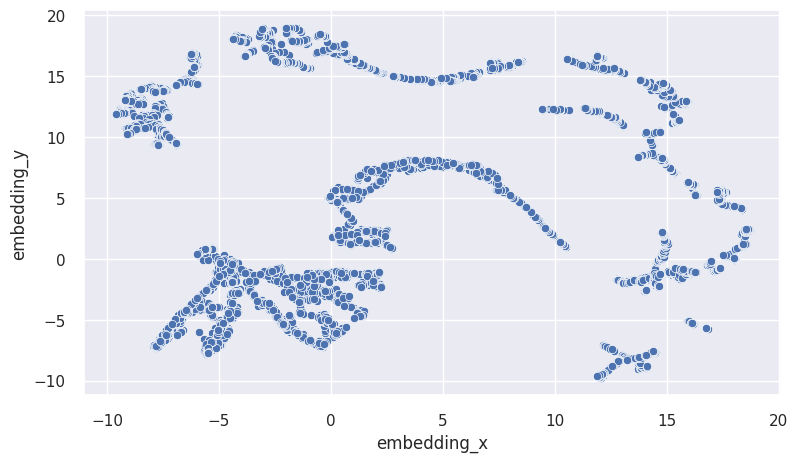

In [54]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

#### 4.3.3 t-SNE

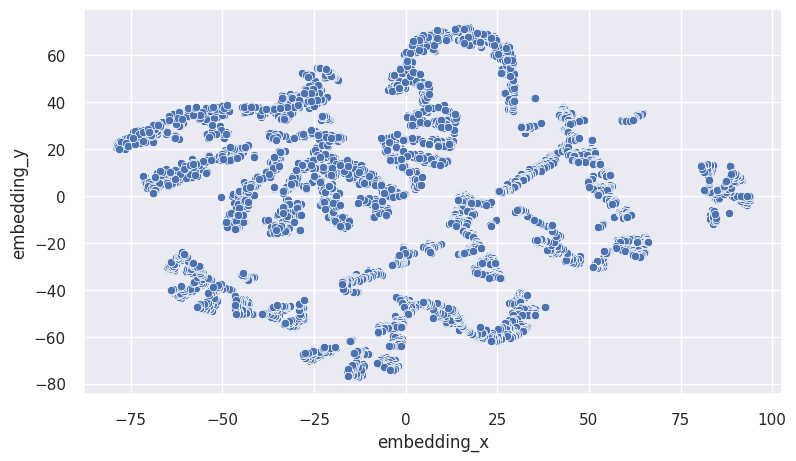

In [55]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

#### 4.3.4 Tree-Based Embedding

In [56]:
X = df43.drop(columns=['gross_revenue'])

# Defining Gross Revenue as target
y = df43['gross_revenue']

# Model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Model training
rf_model.fit(X, y)

# Leafs
df_leaf = pd.DataFrame(rf_model.apply(X))

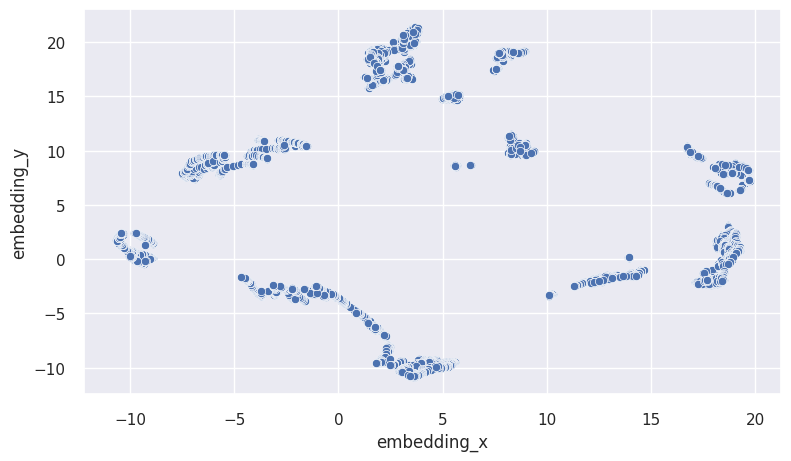

In [57]:
# Reduce dimensionality with UMAP
reducer = umap.UMAP(random_state=42,
                    n_neighbors=170,
                    n_epochs=400,
                    metric='manhattan')

embedding = reducer.fit_transform(df_leaf)

# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tree);

## 5.0 Data Preparation

1. Distribuição Normal Sem Outlier -> Standard Scaler - Media e Desvio Padrão
2. Distribuição Normal Com Outlier -> Robust Scaler - Quartis
3. Distribuição Não Normal - Min Max Scaler

## 6.0 Feature Selection

## 7.0 Hyperparameter Fine-Tunning

In [58]:
# embedded dataset
df7 = df_tree.copy()

In [59]:
df7.columns

Index(['embedding_x', 'embedding_y'], dtype='object')

In [60]:
clusters = np.arange(2, 31, 1)

### 7.1 K-Means

In [61]:
kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = KMeans(n_clusters=k, n_init=100, random_state=7)    

    # Model training
    kmeans_model.fit(df7)

    # Model predict
    labels = kmeans_model.predict(df7)

    # Model performance
    sil = metrics.silhouette_score(df7, labels, metric='euclidean')
    kmeans_list.append(sil)

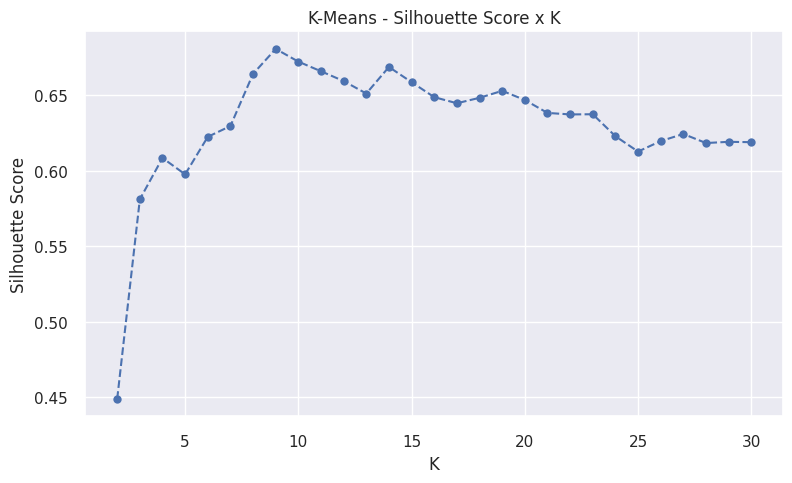

In [62]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('K-Means - Silhouette Score x K');

### 7.1 GMM

In [63]:
gmm_list = []
for k in clusters:
    # Model definition
    gmm_model = GaussianMixture(n_components=k, random_state=7)

    # Model training
    gmm_model.fit(df7)

    # Model predict
    labels = gmm_model.predict(df7)

    # Model performance
    sil = metrics.silhouette_score(df7, labels, metric='euclidean')
    gmm_list.append(sil)

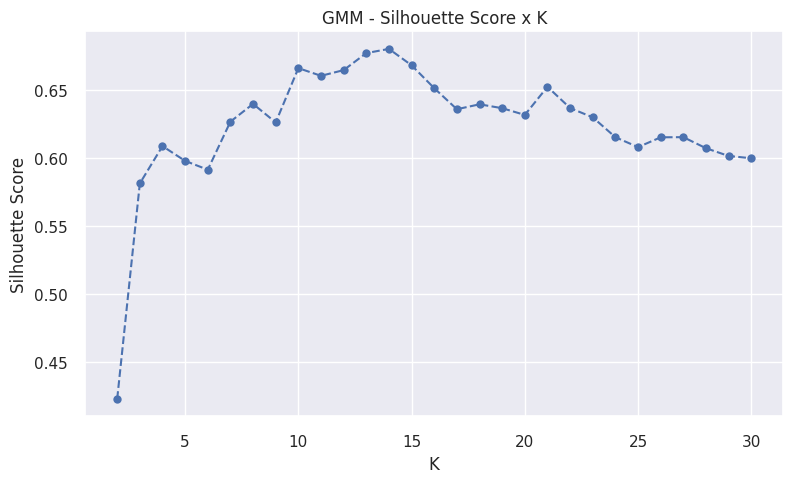

In [64]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM - Silhouette Score x K');

### 7.3 Hierarchical Clutering

### 7.3.1 Dendrograms

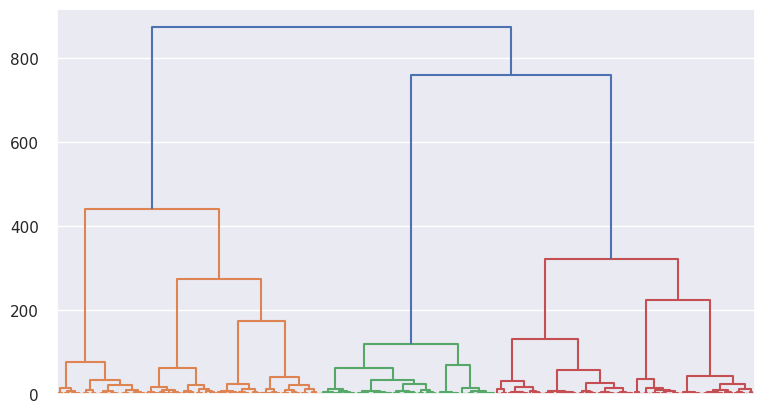

In [65]:
# Model definition and training
hc_model = hc.linkage(df7, 'ward')

hc.dendrogram(hc_model,
              leaf_rotation=90,
              leaf_font_size=8,
              no_labels=True
             )

plt.show();

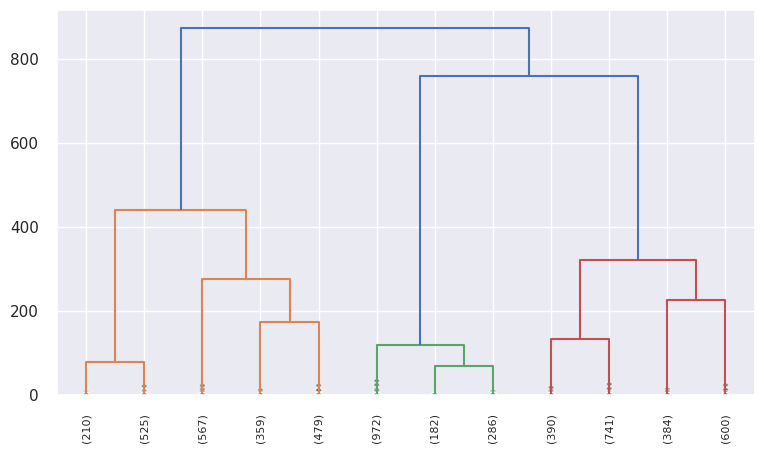

In [66]:
hc.dendrogram(hc_model,
              truncate_mode='lastp',
              p=12,
              leaf_rotation=90,
              leaf_font_size=8,
              show_contracted=True
             )
plt.show();

### 7.3.2 HClustering Silhouette Score

In [67]:
hc_list = []
for k in clusters:
    # Model prediction and training
    hc_model = hc.linkage(df7, 'ward')

    # Model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # Model performance
    sil = metrics.silhouette_score(df7, labels, metric='euclidean')
    hc_list.append(sil)

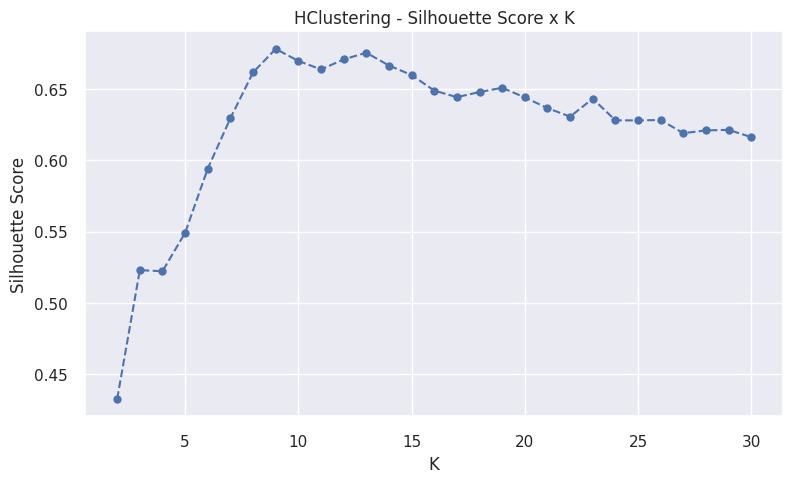

In [68]:
plt.plot(clusters, hc_list, linestyle='--', marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('HClustering - Silhouette Score x K');

## 7.4 DBSCAN

In [69]:
eps = 1
min_samples = 50

# Model definition
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

# Model training & predict
labels = dbscan_model.fit_predict(df7)

# Model performance
sil = metrics.silhouette_score(df7, labels, metric='euclidean')
print(f'Silhouette Score: {sil}')
print(f'Clusters: {np.unique(labels)}')

Silhouette Score: 0.6292441487312317
Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10]


In [70]:
# calculating the distances for each client
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(df7)
distances, indeces = neighbors.kneighbors(df7)

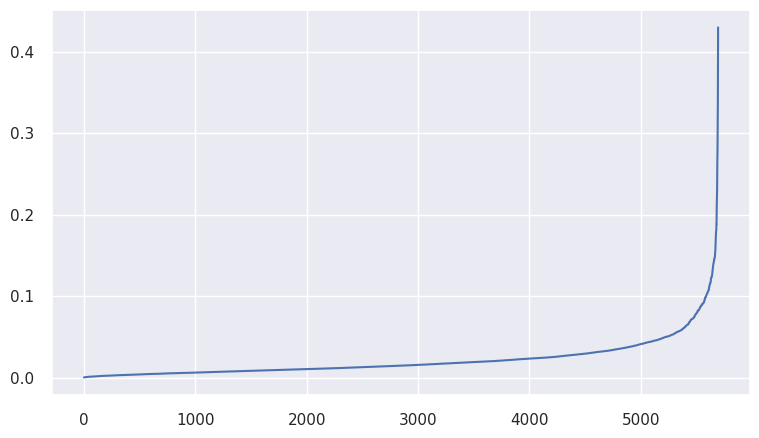

In [71]:
# sorting and ploting distance for elbow visualization
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances);

### 7.5 Results

In [72]:
# Comparing Silhouette Scores
df_results = pd.DataFrame({'Kmeans': kmeans_list,
                           'GMM': gmm_list,
                           'H-Clustering': hc_list}
                           #'DBSCAN': dbscan_list
                           ).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

### 7.6 Silhouette Analysis

#### 7.6.1 K-Means

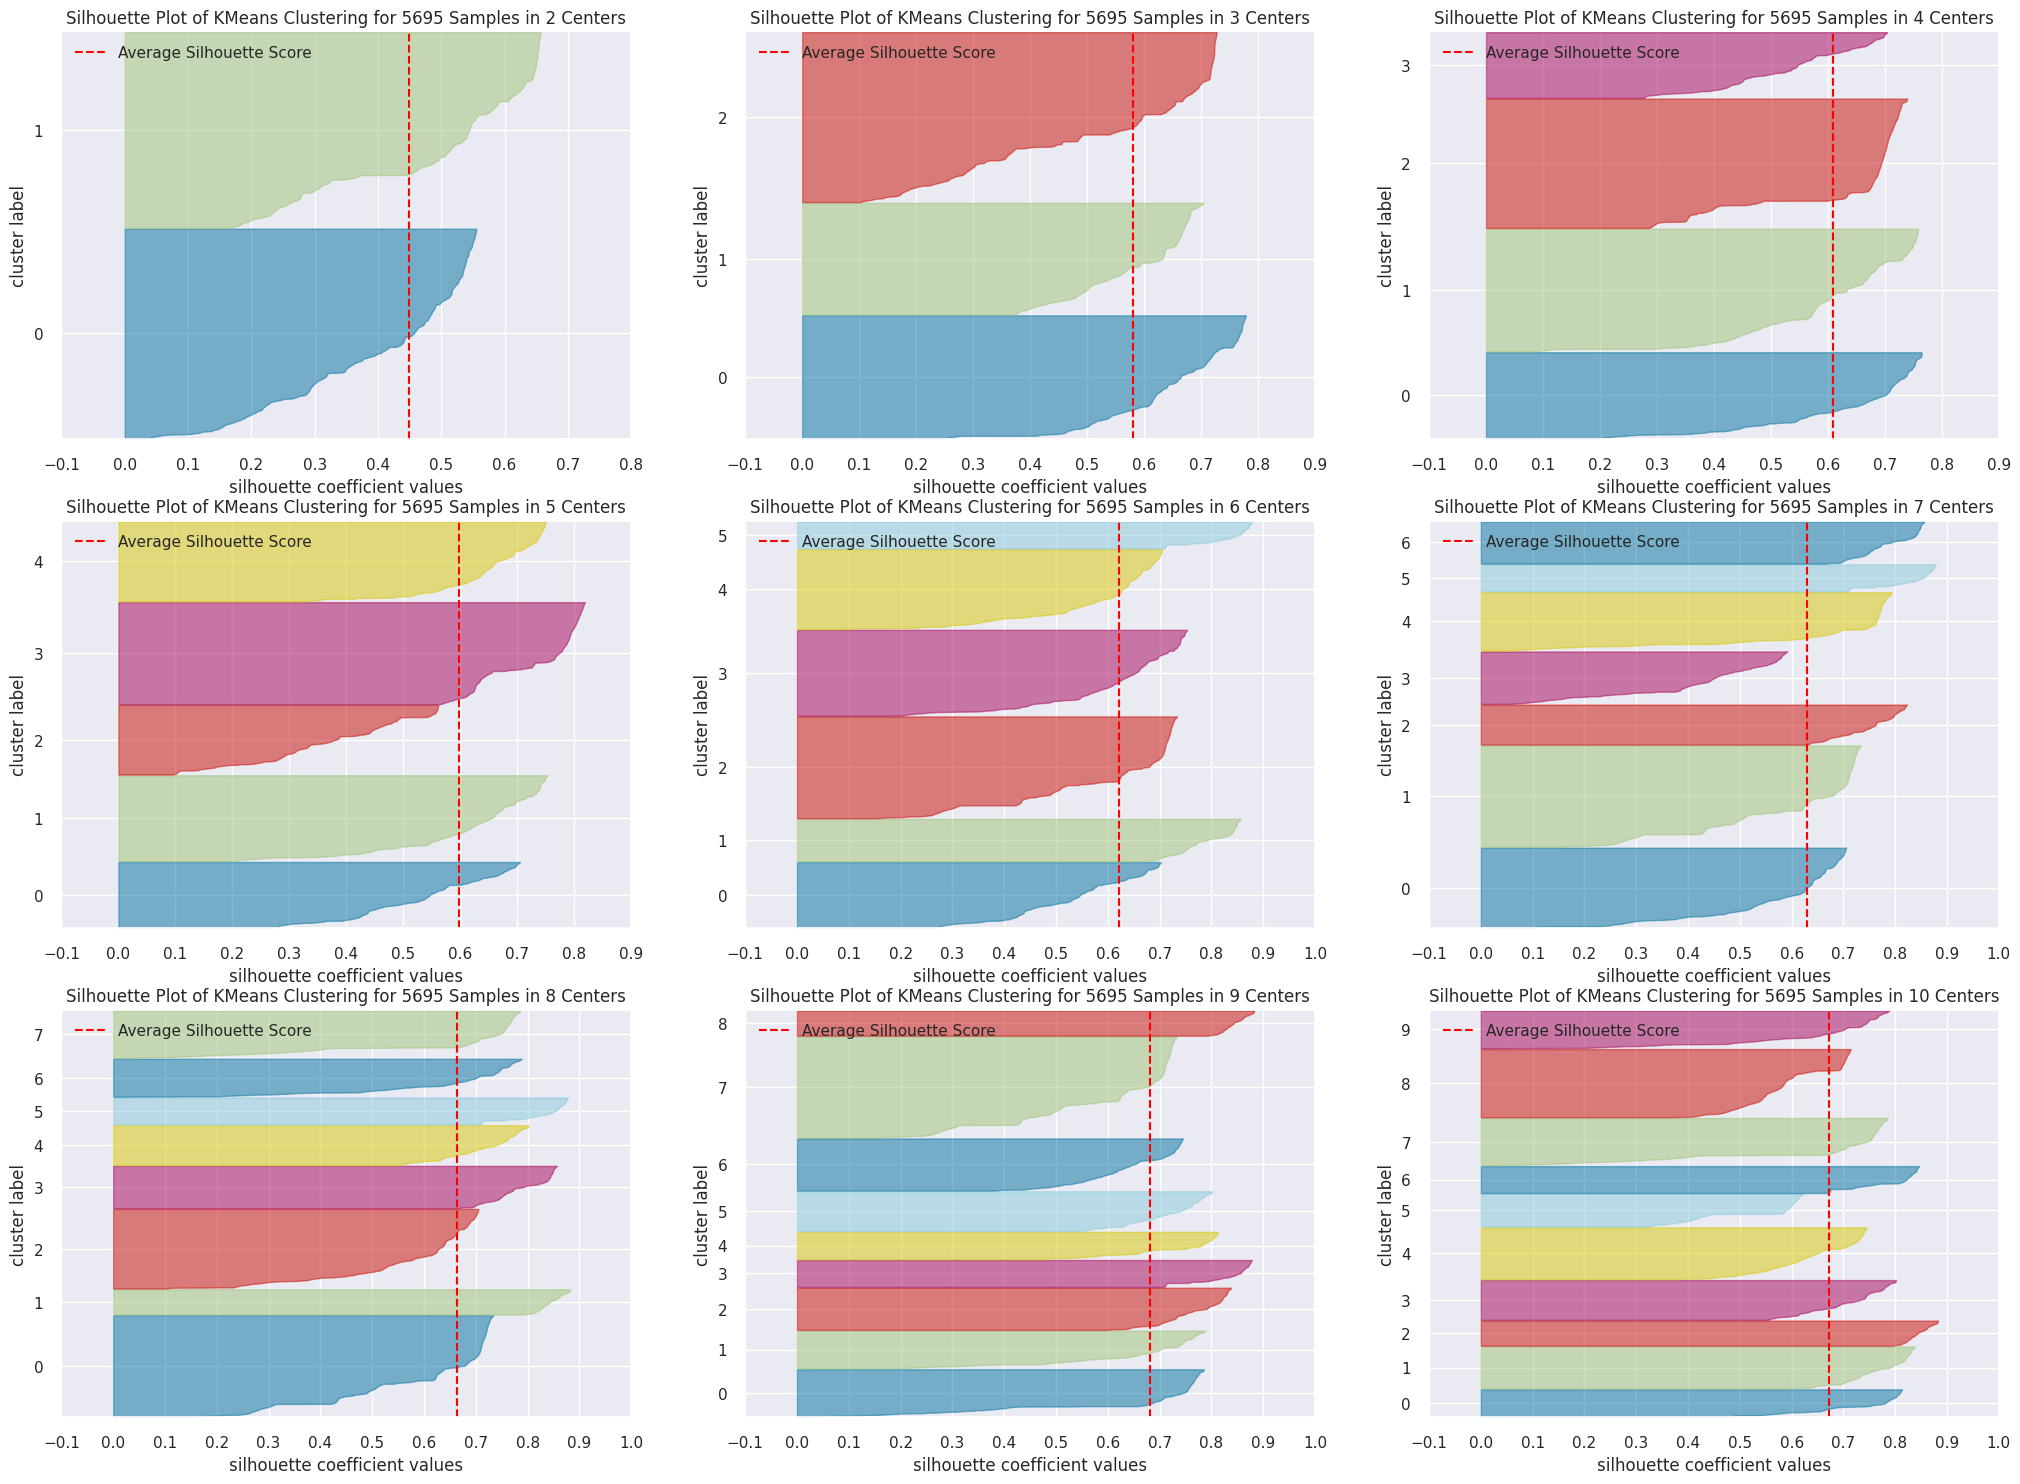

In [73]:
fig, ax = plt.subplots(3, 3, figsize=(25,18))
                      
for i, k in enumerate(clusters[:9]):
    
    q, mod = divmod(i, 3)
    
    # Model definition
    km = KMeans(n_clusters=k, init='random', n_init=300, max_iter=300, random_state=42)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(df7)
    visualizer.finalize();

#### 7.6.2 GMM

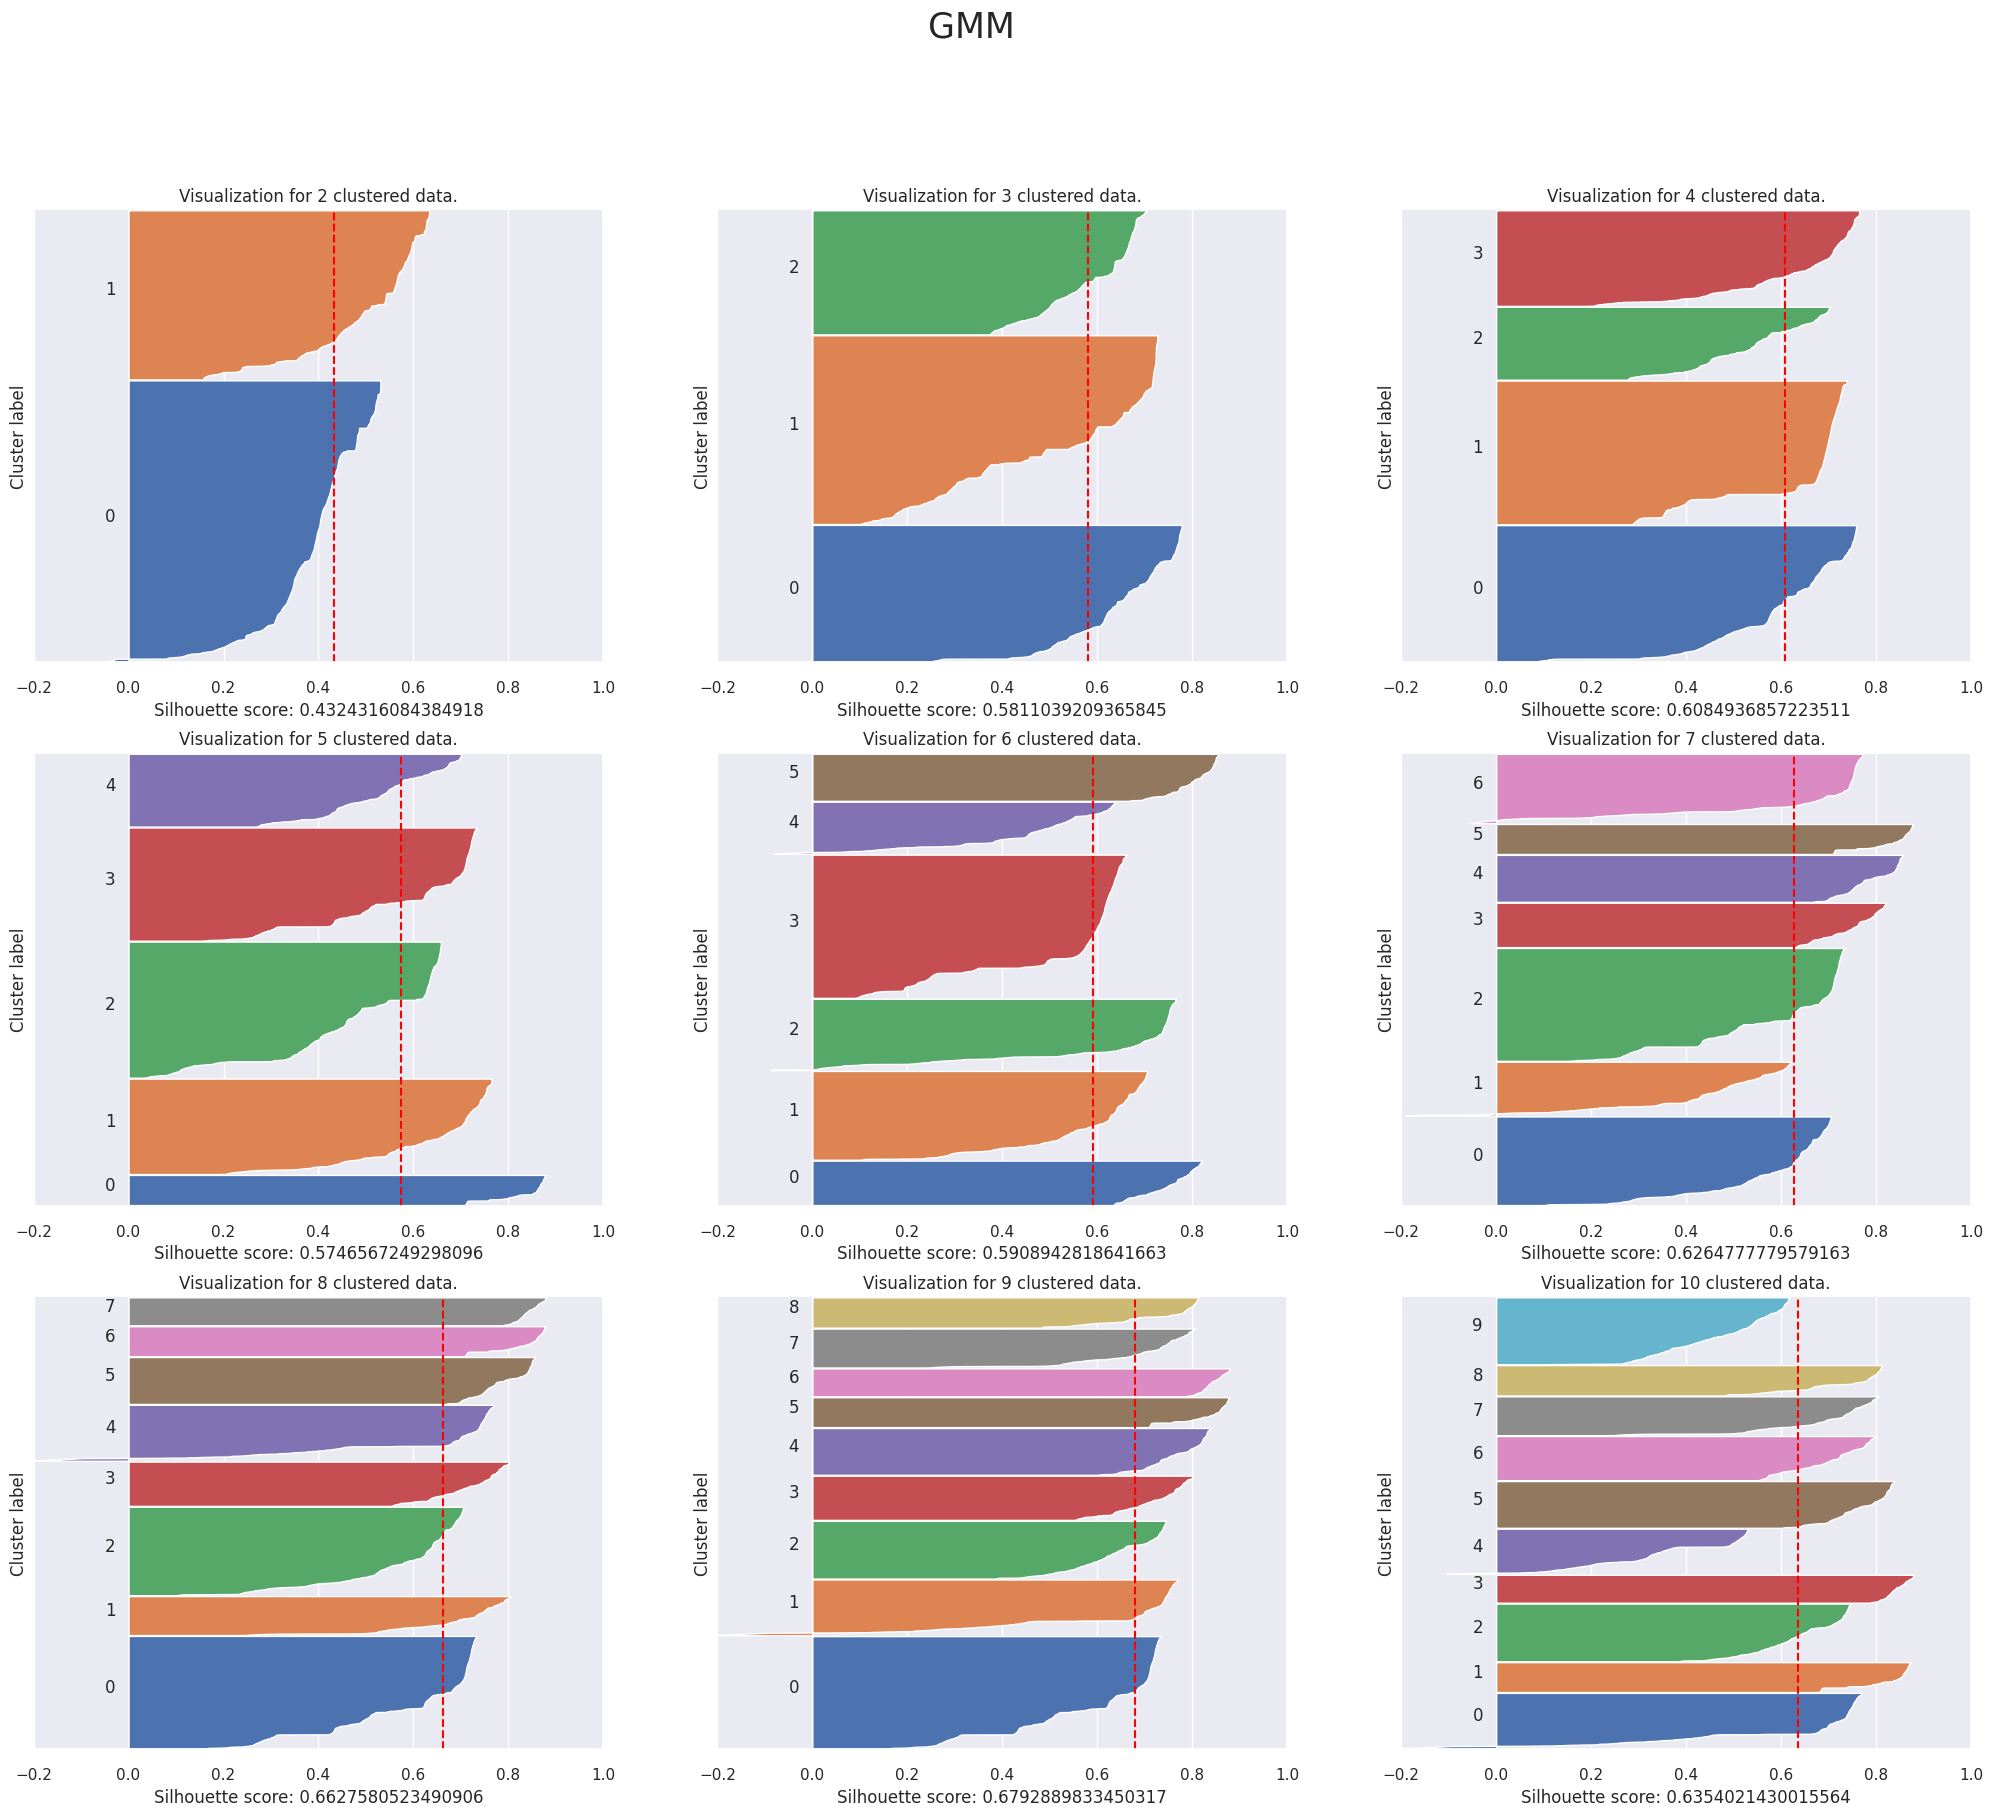

In [74]:
# Silhouette plot
silhouette_plots('gmm',clusters,df7)

#### 7.6.3 H-Clustering

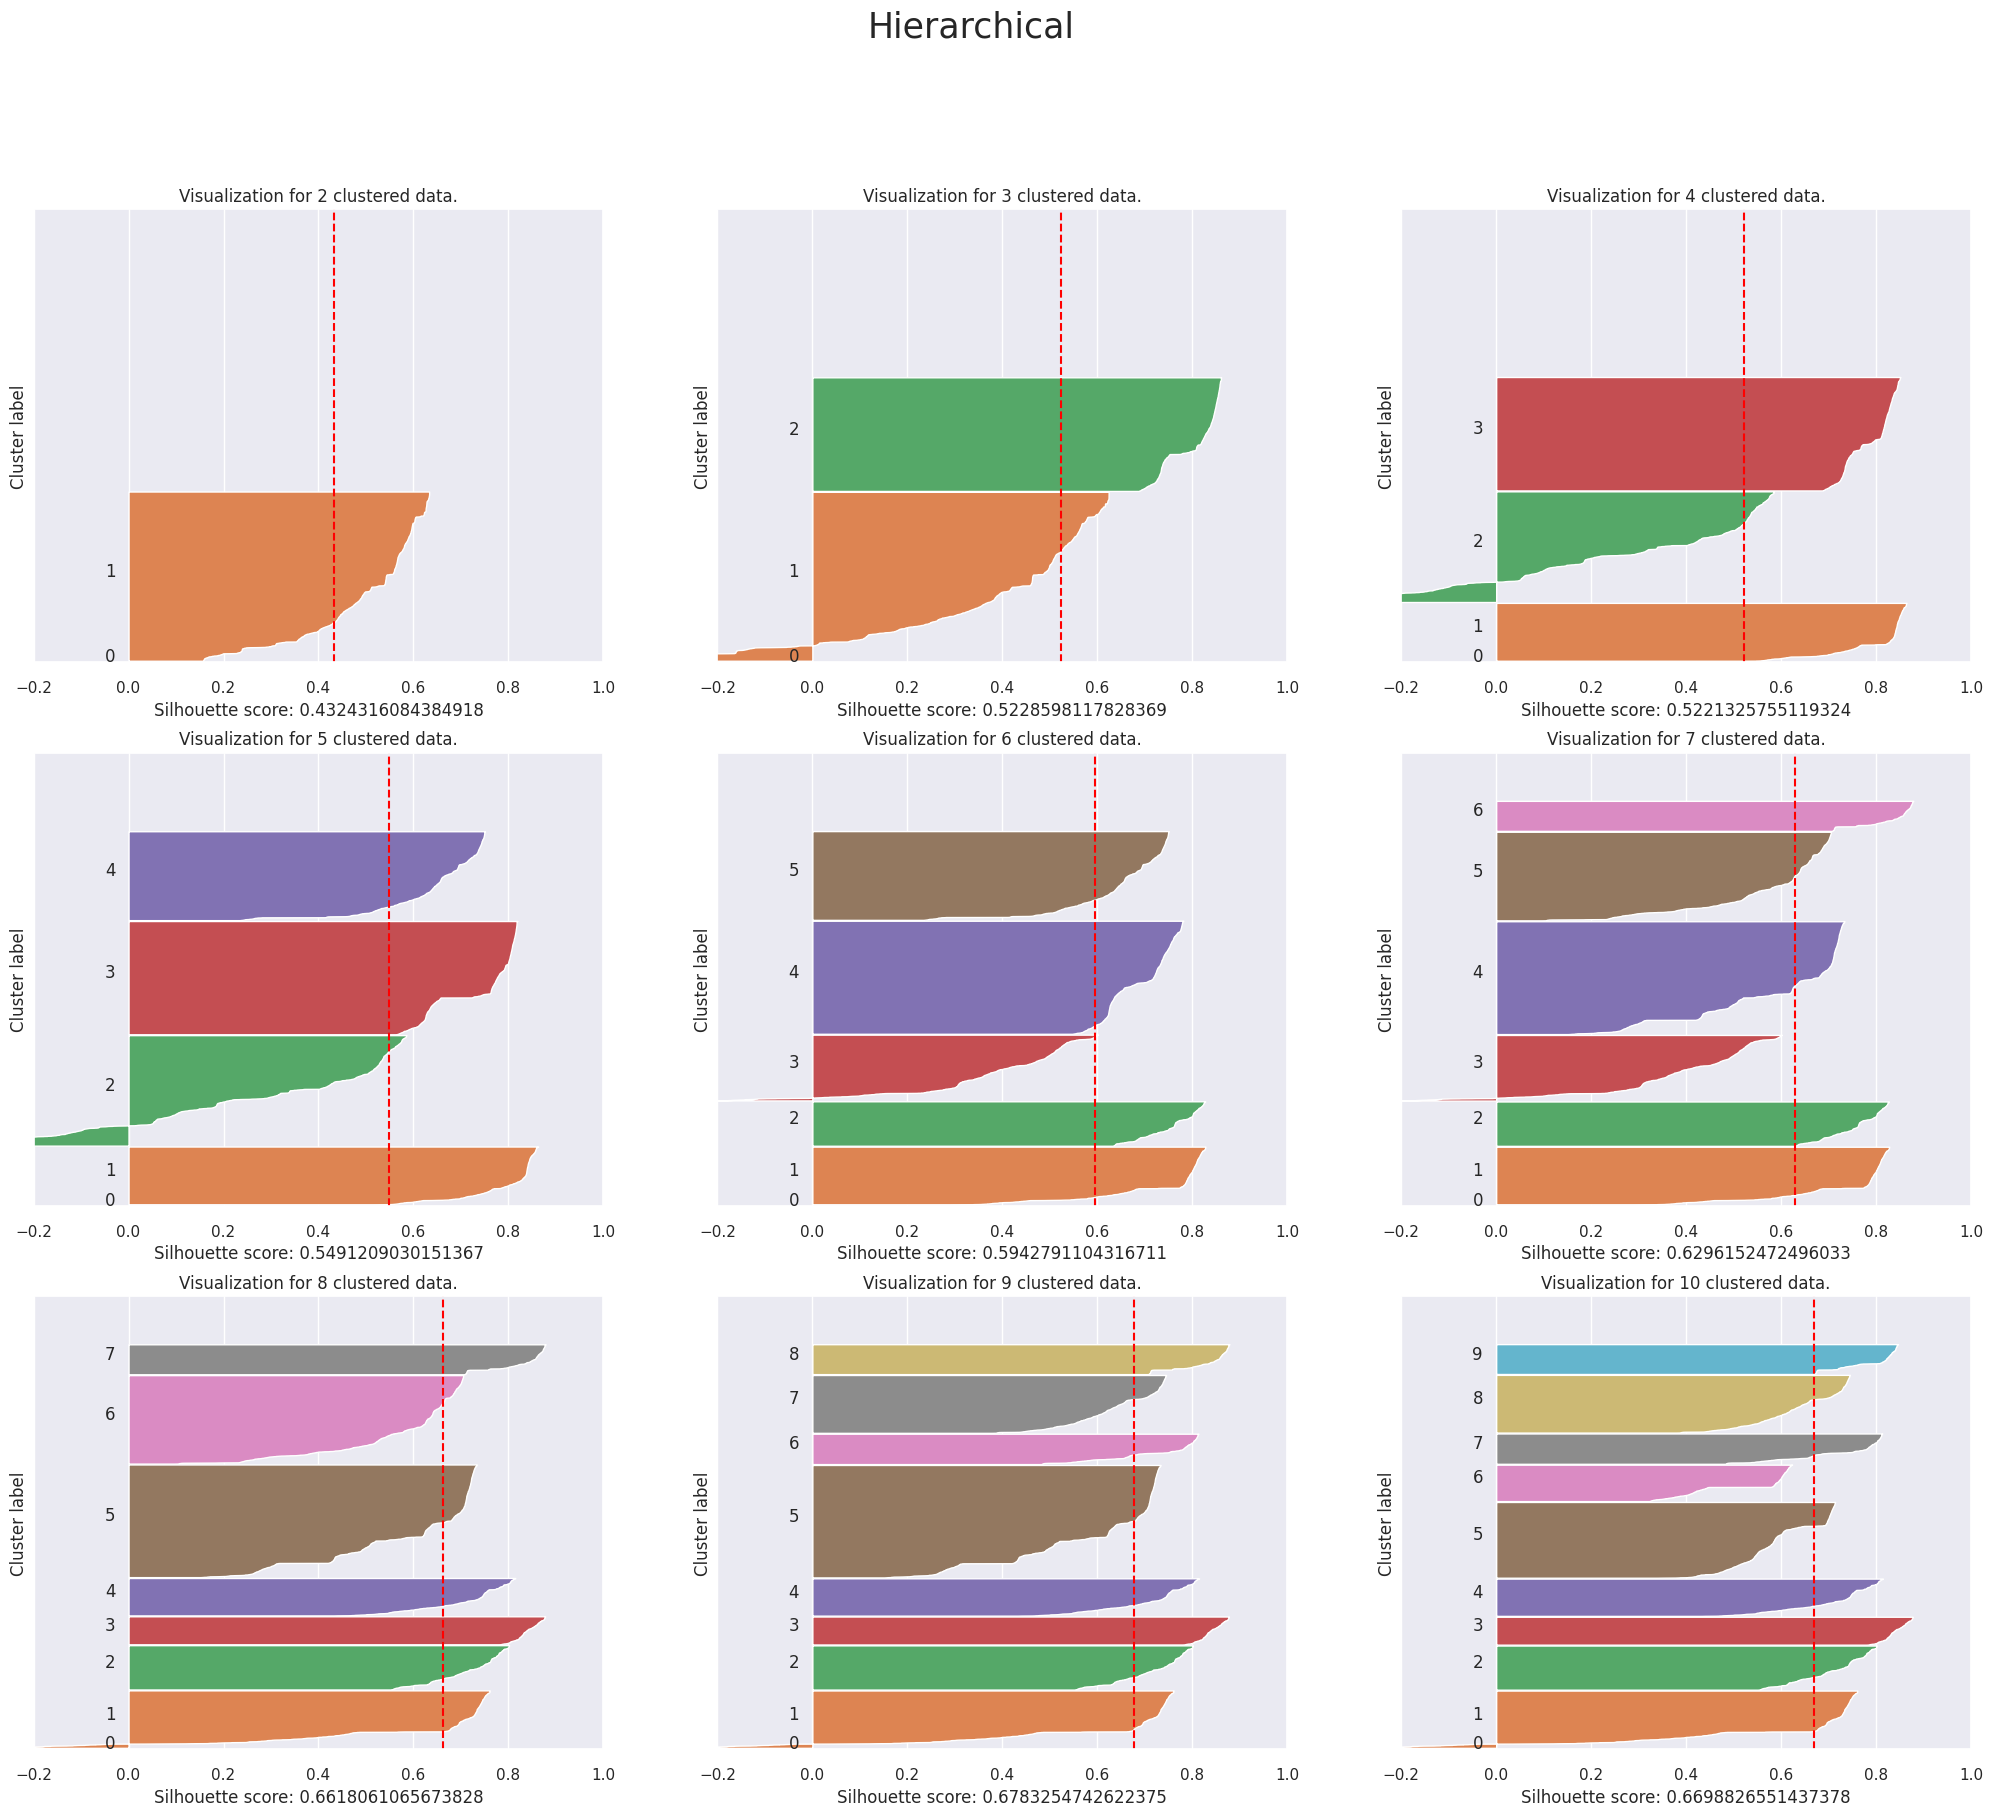

In [75]:
#Silhouette plot
silhouette_plots('hc',clusters,df7)

## 8.0 Model Training

In [76]:
df8 = df7.copy()

### 8.1 Final Model - K-Means

In [77]:
# Model definition
k = 9
kmeans = KMeans(init='random', n_clusters=k, n_init=300, max_iter=300, random_state=42)

# Model training
kmeans.fit(df8)

# Clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [78]:
# WSS (Within-Cluster Sum of Squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (Silhouette Score)
print('Silhouette Score: {}'.format(metrics.silhouette_score(df8, labels, metric='euclidean')))

WSS value: 25714.943359375
Silhouette Score: 0.6807411909103394


## 9.0 Cluster Analysis

In [79]:
df9 = df8.copy()
df9['cluster'] = labels

### 9.1 Visualization Inspection

#### 9.1.1 Silhouette Analysis

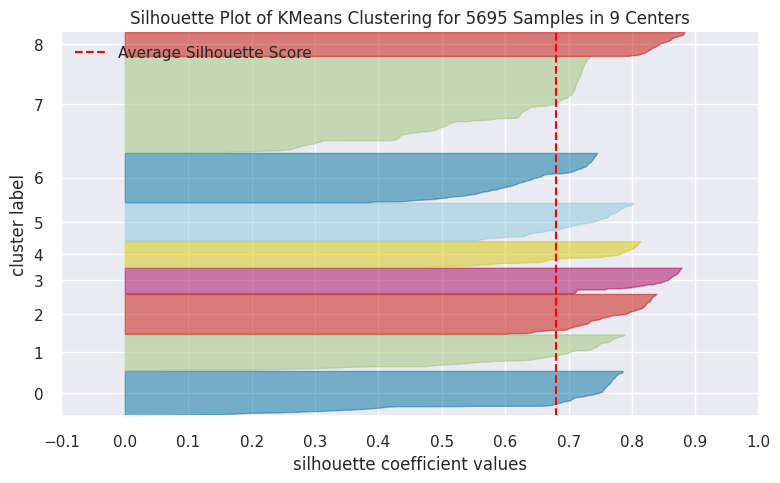

In [81]:
# Silhouette Analysis
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df8)
visualizer.finalize()

#### 9.1.2 2d plot

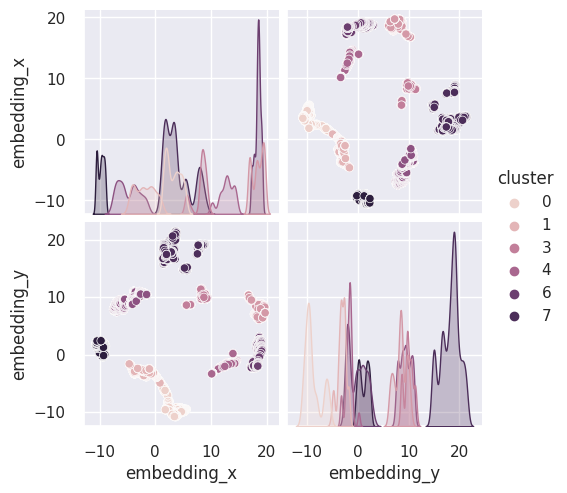

In [82]:
# Pair plot
df_viz = df9.copy()
sns.pairplot(df_viz, hue='cluster');

#### 9.1.3 UMAP

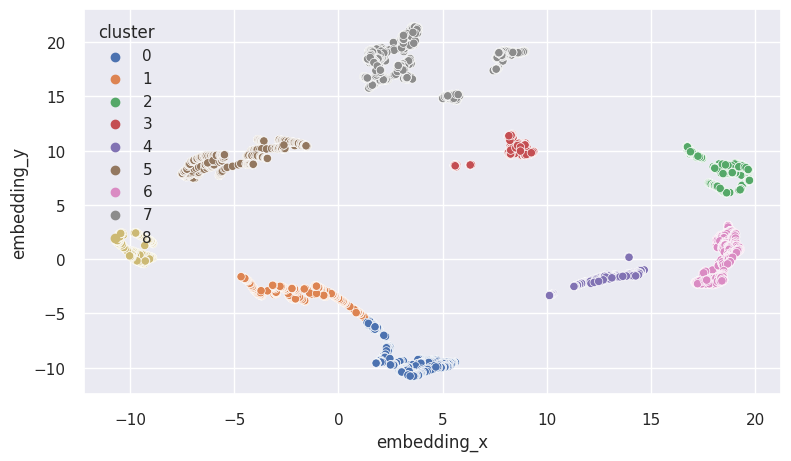

In [80]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

### 9.2 Cluster Profile

In [84]:
# cols_selected: ['gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']
df9 = df4[['customer_id']+cols_selected]
df9['cluster'] = labels

# Number of customers
df_cluster = df9.groupby('cluster')['customer_id'].count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id']/df_cluster['customer_id'].sum()*100

# Avg Gross Revenue
df_avg_gross_revenue = df9.groupby('cluster')['gross_revenue'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_avg_recency_days= df9.groupby('cluster')['recency_days'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg Products quantity
df_avg_qty_products = df9.groupby('cluster')['qty_products'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qty_products, how='inner', on='cluster')

# Frequency
df_avg_frequency = df9.groupby('cluster')['frequency'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

# Returns
df_avg_qty_returns = df9.groupby('cluster')['qty_returns'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_qty_returns, how='inner', on='cluster')

df_cluster = df_cluster.sort_values('gross_revenue', ascending=False, ignore_index=True)

df_cluster['cluster'] = ['Insiders',
                         'Leais',
                         'Potenciais',
                         'Novos',
                         'Acompanhar',
                         'Promissor',
                         'Prestes a perder',
                         'Perdendo',
                         'Hibernando']

In [85]:
df_cluster

cluster  customer_id  perc_customer  gross_revenue  recency_days  qty_products  frequency  qty_returns
0          Insiders          600          10.54        7736.39         59.31        253.34       0.26       254.02
1             Leais          384           6.74        2336.05         57.63         69.10       0.04        45.11
2        Potenciais          390           6.85        2083.69        158.94         66.53       1.06         1.29
3             Novos          741          13.01        2081.56        102.42        152.82       0.47         0.31
4        Acompanhar         1440          25.29        1167.69         69.22         33.45       0.03         3.11
5         Promissor          675          11.85         394.87        186.01         28.71       1.01         1.88
6  Prestes a perder          539           9.46         284.69        136.00         14.50       0.99         2.83
7          Perdendo          359           6.30         160.42        178.43          6.96       1.00         0.76
8        Hibernando          567           9.96          90.49        189.96          1.99       1.00         0.13

## 10.0 EDA

**The Insiders cluster has a product purchase volume of 40%**

In [86]:
# sum of quantity of products from Insiders
df_sales_insiders = df_cluster.loc[df_cluster['cluster'] == 'Insiders', 'qty_products'].sum()

# total quantity of producst
df_sales_total = df_cluster.loc[:, 'qty_products'].sum()

print(f'% Sales Insiders: {df_sales_insiders/df_sales_total:.2%}')

% Sales Insiders: 40.38%


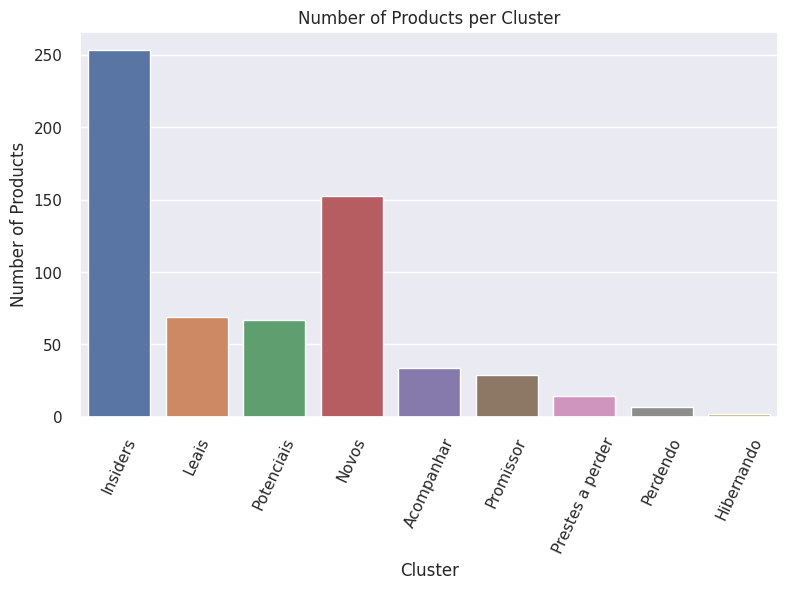

In [87]:
ax = sns.barplot(y='qty_products', x='cluster', data=df_cluster)
plt.xlabel('Cluster')
plt.ylabel('Number of Products')
plt.title('Number of Products per Cluster')
plt.xticks(rotation=65);

**The Insiders cluster has a GMV volume of 47%.**

In [88]:
# gross revenue from Insiders
df_gvm_insiders = df_cluster.loc[df_cluster['cluster'] == 'Insiders', 'gross_revenue'].sum()

# total gross revenue
df_gvm_total = df_cluster.loc[:, 'gross_revenue'].sum()

print(f'% Sales Insiders: {df_gvm_insiders/df_gvm_total:.2%}')

% Sales Insiders: 47.36%


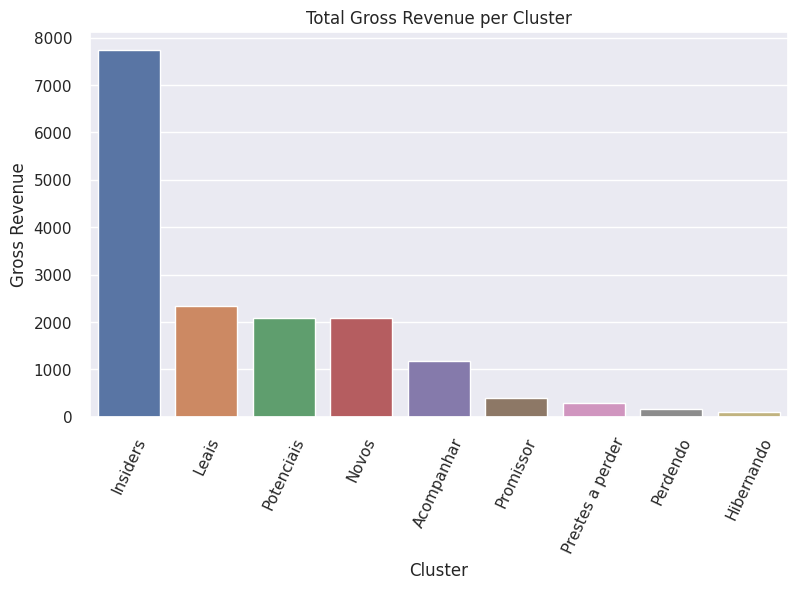

In [89]:
ax = sns.barplot(y='gross_revenue', x='cluster', data=df_cluster)
plt.xlabel('Cluster')
plt.ylabel('Gross Revenue')
plt.title('Total Gross Revenue per Cluster')
plt.xticks(rotation=65);

**The Insiders cluster averages bounces above the overall average.**

In [90]:
# mean of returns from cluster Insiders
df_avg_insiders = df_cluster.loc[df_cluster['cluster'] == 'Insiders', 'qty_returns'].mean()

# mean of returns for total database
df_avg_returns_total = df_cluster['qty_returns'].mean()

print(f'Average Returns Insiders: {df_avg_insiders:.0f} vs Average Returns All: {df_avg_returns_total:.0f}')

Average Returns Insiders: 254 vs Average Returns All: 34


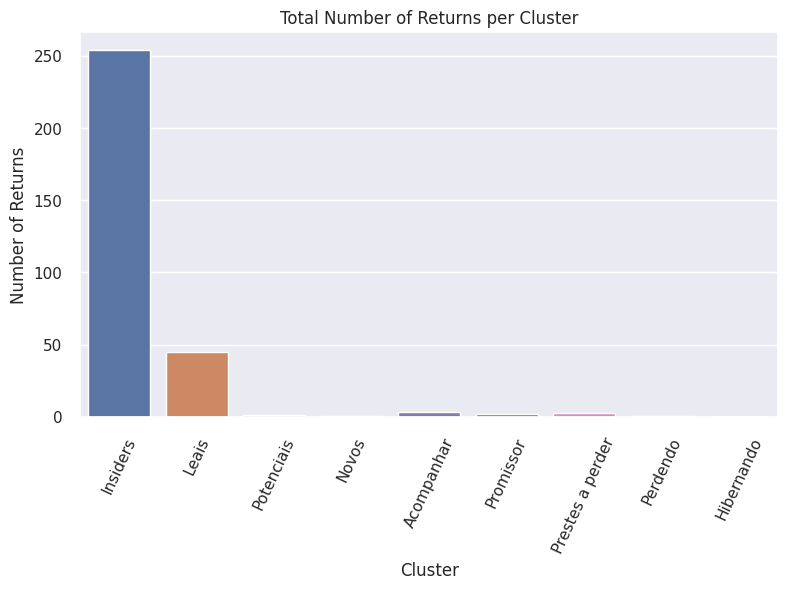

In [91]:
ax = sns.barplot(y='qty_returns', x='cluster', data=df_cluster)
plt.xlabel('Cluster')
plt.ylabel('Number of Returns')
plt.title('Total Number of Returns per Cluster')
plt.xticks(rotation=65);

**The median turnover of the Insiders cluster is more than 500 times higher than the others.**

In [92]:
# median gmv from Insiders
df_median_gmv_insiders = df_cluster.loc[df_cluster['cluster'] == 'Insiders', 'gross_revenue'].median()

# median gmv total
df_median_gmv_total = df_cluster.loc[:, 'gross_revenue'].median()

gmv_diff = ((df_median_gmv_insiders - df_median_gmv_total)/df_median_gmv_total)
print(f'Median Diff: {gmv_diff:.2%}')

Median Diff: 562.54%


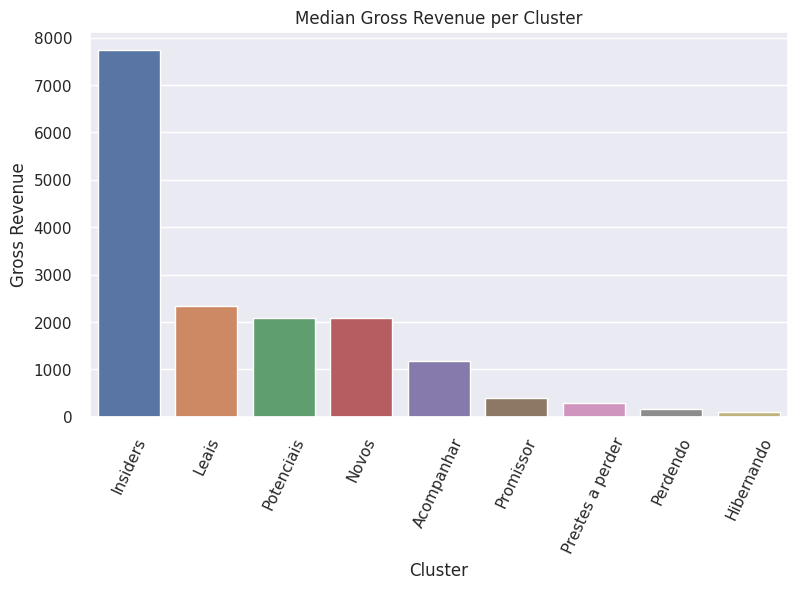

In [93]:
aux = df_cluster.groupby('cluster')[['gross_revenue']].median().sort_values(by='gross_revenue', ascending=False).reset_index()
sns.barplot(aux, y='gross_revenue', x='cluster')
plt.xlabel('Cluster')
plt.ylabel('Gross Revenue')
plt.title('Median Gross Revenue per Cluster')
plt.xticks(rotation=65);